# Defining Utility Functions

In [2]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [4]:
def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        cur = conn.cursor()
        cur.execute(q)

In [5]:
def show_tables():
    tables = """
    SELECT 
        name, type 
    FROM sqlite_master 
    WHERE type IN ('table', 'view')
    """
    return run_query(tables)

In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Selecting new albums to purchase

In [7]:
tracks_sold_usa_query = """
WITH usa_customers AS
    (
    SELECT
        *
     FROM
        invoice_line inl
     INNER JOIN invoice i ON inl.invoice_id = i.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
     WHERE country = "USA"
    )
SELECT
    g.name Genre,
    SUM(usa.quantity) tracks_sold,
    ROUND((CAST(SUM(usa.quantity) AS FLOAT) / (
        SELECT COUNT(*) FROM usa_customers) * 100), 2)
        percentage_sold
FROM
    usa_customers usa
INNER JOIN track t ON usa.track_id = t.track_id
INNER JOIN genre g ON t.genre_id = g.genre_id
GROUP BY Genre
ORDER BY tracks_sold DESC
LIMIT 5
"""
run_query(tracks_sold_usa_query)

,Genre,tracks_sold,percentage_sold
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43


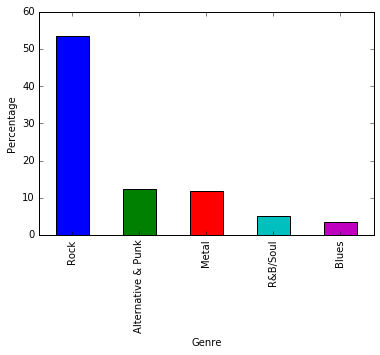

In [8]:
df = run_query(tracks_sold_usa_query)
df.set_index("Genre", drop=True, inplace=True)
ax = df.plot.bar(legend=False, y="percentage_sold")
ax.set_ylabel("Percentage")

## Summary
Based on the table and plot above, Rock, Alternative & Punk, and Metal are the top three choices of music for audience in the United States. 

If we have to select music by three out of the four artists above, then we would select:
* Red Tone (Punk)
* Meteor and the Girls (Pop)
* Slim Jim Bites (Blues)

It is also worth noting that these three genres make up only about 17% of the total sales, so it would be more desirable to get artists that produce music in the Rock genre.

# Selecting employees with the highest total sales

In [9]:
sales_rep_query = """
SELECT
    e.first_name || " " || e.last_name Name,
    SUM(i.total) total_sales,
    e.hire_date
FROM employee e
INNER JOIN customer c ON e.employee_id = c.support_rep_id
INNER JOIN invoice i ON c.customer_id = i.customer_id
GROUP BY Name
"""
run_query(sales_rep_query)

,Name,total_sales,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


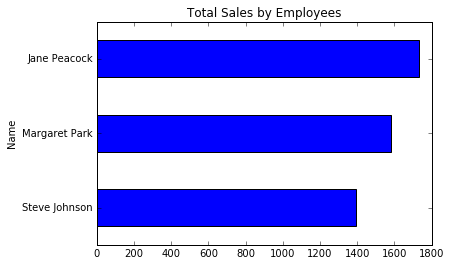

In [10]:
top_sales_rep = run_query(sales_rep_query)
top_sales_rep.set_index("Name", drop=True, inplace=True)
top_sales_rep.sort_values("total_sales", inplace=True)
top_sales_rep.plot.barh(legend=False, 
                        title="Total Sales by Employees",
                        colormap=plt.cm.winter)

The above plot breaks down the total sales by employees. Jane Peacock has the highest sales and is the oldest employee out of the three. Steve Johnson has the lowest sales and is the newest employee. 

The hire date of the employee can be attributed to the level of their sales, although this is just speculation based on the results above.

In [11]:
diff_countries = """
WITH all_countries AS
(
    SELECT 
        c.country Country,
        COUNT(DISTINCT(c.customer_id)) tot_customers,
        SUM(inv.total) tot_sales,
        (SUM(inv.total) / COUNT(inv.invoice_id)) "Avg Order Value"
    FROM customer c
    INNER JOIN invoice inv on inv.customer_id = c.customer_id
    GROUP BY 1
)

SELECT 
    CASE
        WHEN tot_customers = 1 THEN "Others"
        ELSE Country
    END AS Country,
    SUM(tot_customers) AS Customers,
    SUM(tot_sales) "Total Sales",
    ROUND((SUM(tot_sales) / SUM(tot_customers)), 2) 
    "Average Sales / Customer",
    ROUND("Avg Order Value", 2) "Avg Order Value"
FROM all_countries
GROUP BY 
    CASE
        WHEN tot_customers = 1 THEN "Others"
        ELSE Country
    END
ORDER BY tot_sales DESC
"""
run_query(diff_countries)

,Country,Customers,Total Sales,Average Sales / Customer,Avg Order Value
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.57,6.38
8,India,2,183.15,91.57,8.72
9,Others,15,1094.94,73.00,7.52


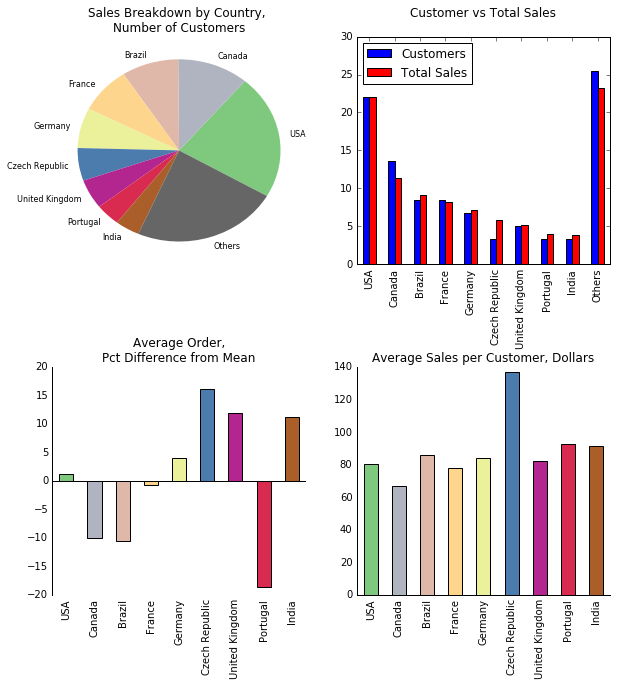

In [12]:
sales_data_by_country = run_query(diff_countries)
sales_data_by_country.set_index("Country", drop=True, inplace=True)
colors = [cm.Accent(i) for i in np.linspace(0, 1, sales_data_by_country.shape[0])]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.45)
ax1, ax2, ax3, ax4 = axes.flatten()

# top left 
sales_analysis = sales_data_by_country["Total Sales"].copy().rename("")
sales_analysis.plot.pie(
    ax=ax1,
    startangle=-30,
    title="Sales Breakdown by Country, \nNumber of Customers",
    colormap=cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    )

#top right
cad_cols = ["Customers", "Total Sales"]
cust_and_doll = sales_data_by_country[cad_cols].copy()
#cust_and_doll.set_index("Country", drop=True, inplace=True)
cust_and_doll.index.name = ''
for i in cad_cols:
    cust_and_doll[i] /= cust_and_doll[i].sum() / 100
cust_and_doll.plot.bar(
    ax=ax2,
    colormap=cm.bwr,
    title="Customer vs Total Sales\n"
    )
# bottom left
avg_order = sales_data_by_country["Avg Order Value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Others", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = sales_data_by_country["Average Sales / Customer"].copy()
ltv.index.name = ''
ltv.drop("Others",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Average Sales per Customer, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

Based on the above information, the following companies may have potential for growth:
* Czech Republic
* India
* United Kingdom

Before launching any new marketing campaigns in these countries, Chinook should be cautious of the results due to the small amount of data that we had. We cannot present these results with high confidence. Small campaigns should be launched in these countries, collecting and analyzing information about the new customers and confirming whether these trends are true for the new customers. 

In [18]:
albumOrNot = """
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
"""
run_query(albumOrNot)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


The Chinook store should not discontinue buying albums from record companies because they make up approximately 18% of revenue.